In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold

# Set the default font family to Times New Roman, default tick label color to black, and default line plot style
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors) + plt.cycler("marker", ["o", "s", "D", "v", "X", "P", ">", "<", "H", "d"])  # Set the default line plot style



# Function to create RNN dataset
def create_rnn_dataset(X_norm, y_scaled, lookback):
    X, y = [], []
    for i in range(len(X_norm)-lookback):
        X.append(X_norm[i:(i+lookback)])
        y.append(y_scaled[(i+lookback)])
    return np.array(X), np.array(y)


# Define a function to calculate performance metrics
def calculate_performance(observed, predicted):
    mse = mean_squared_error(observed, predicted)
    mae = mean_absolute_error(observed, predicted)
    rmse = math.sqrt(mse)
    r2 = r2_score(observed, predicted)
    
    return float(mse), float(mae), float(rmse), float(r2)

In [2]:
# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU is being used')
    except RuntimeError as e:
        print(e)

GPU is being used


In [21]:
data_true = pd.read_csv(r"G:\My Drive\Google Drive - VirginiaTech\OneDrive - Virginia Tech\01_Terms\02_Fall_2024\Projects\DownloadedData\NOAA\ModelMergedData\KK_ML_Project_UTF-8 _All_Variables.csv")
print(data_true.dtypes)
#drop the date column, all data are at 1hr interval. Timestamp has no additional values
data = data_true.drop(columns=['DateTime (GMT)']) 

DateTime (GMT)       object
HT (m)              float64
NTR (m)             float64
MSL (Pa)            float64
SST (°C)            float64
Air_Temp (°C)       float64
Wind Speed (m/s)    float64
TWL (m)             float64
dtype: object


In [22]:
# Load Fortmyers latest.csv dataset
X = data.iloc[:,:-1]  # All columns excepect the last column (target variable)
y = data.iloc[:, -1]  # The target variable

# Step 1: Normalize the data using MinMaxScaler
# Note: HT (m), NTR (m) can be scaled from -1 to 1 as the magnitude both has negative and positive values
# Simialarly Wind Speed (m/s) and Wind Gist (m/s) has been scaled from 0 to 1 because there are no negative values here.
# Likewise, the target varibale has been scaled from -1 to 1.
######################### HOWEVER #######################################
# As scaling HT and NTR from -1 to 1 preserves their positive and negative values, while Wind Speed and Wind Gust are appropriately scaled
# from 0 to 1 due to their non-negative nature. Similarly, scaling the target variable from -1 to 1 is beneficial if it has both positive
# a nd negative values. However, using different scaling ranges for features may cause some models, like neural networks, to focus
# disproportionately on certain variables, potentially slowing convergence. To mitigate this, consider experimenting with
# uniform scaling across all features for better consistency, especially in models that are sensitive to feature magnitudes.

########################## Therefore, as a start, all input varibales are scaled from -1 to 1 and all target varibales are scaled from -1 to 1.
########################## A future trail will be held to see if HT (m), NTR (m) can be scaled from 0 to 1, 
########################### and Wind Speed (m/s) and Wind Gist (m/s) scaled from 0 to 1 can help to improve the model.
########################### so as a start all input variables are scaled from -1 to 1. Including the windspeed and wind gust.

##### Therefore, speperate scaling algorithms are set for input and target varibales

# Step 1: Initialize MinMaxScaler for X (features) and set range to (-1, 1) 
# this can be later changed into 0 to 1
scaler_X = MinMaxScaler(feature_range=(-1, 1))
# scaler_X = MinMaxScaler(feature_range=(0, 1))
X_norm = scaler_X.fit_transform(X)

# Initialize MinMaxScaler for y (target) and set range to (-1, 1)
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape y to a 2D array since MinMaxScaler expects a 2D input
y_reshaped = y.values.reshape(-1, 1)

# Fit and transform the target variable (y) to scale it between -1 and 1
y_scaled = scaler_y.fit_transform(y_reshaped)

# Inverse transform the scaled target variable back to the original scale
# This is done so that we can calcualte performance metrics
y_original = scaler_y.inverse_transform(y_scaled)



In [23]:
# Check for NaN values in scaled data
print("Check for NaN in X_norm after scaling:", np.isnan(X_norm).sum())
print("Check for NaN in y_scaled after scaling:", np.isnan(y_scaled).sum())
print("-----------------------------------------------------------")

# Print the minimum and maximum values of the scaled data
min_value_X = np.min(X_norm)
max_value_X = np.max(X_norm)
print("Minimum value of scaled data (X):", min_value_X)
print("Maximum value of scaled data (X):", max_value_X)
print("-----------------------------------------------------------")
min_value_y = np.min(y_scaled)
max_value_y = np.max(y_scaled)
print("Minimum value of scaled data (y):", min_value_y)
print("Maximum value of scaled data (y):", max_value_y)

Check for NaN in X_norm after scaling: 0
Check for NaN in y_scaled after scaling: 0
-----------------------------------------------------------
Minimum value of scaled data (X): -1.0
Maximum value of scaled data (X): 1.0000000000000004
-----------------------------------------------------------
Minimum value of scaled data (y): -1.0
Maximum value of scaled data (y): 0.9999999999999999


In [24]:
print(X_norm.shape)
print(y_scaled.shape)

(61369, 6)
(61369, 1)


In [25]:
#Training data 
data_spilt=0.80
train_size = int(0.80 * len(X_norm))
print('Data Split(%): ', data_spilt*100)
print('---------------------------------')
# Split the preprocessed dataset into training and testing sets
X_train = X_norm[:train_size]
X_test = X_norm[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

# lookback samples. Initially starting at 4 hours, 1/3 of one single tide cycle. Will be updated later 3,4,5,6 .
lookback= 12
# Define the number of input features
num_input_features = X_norm.shape[1]

# Define the number of output fea.shape[1]tures
num_output_features = y_scaled.shape[1]

# Split the preprocessed dataset into training and testing sets
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_test:", X_test.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_test:", y_test.shape[0])


Data Split(%):  80.0
---------------------------------
Number of samples in X_train: 49095
Number of samples in X_test: 12274
Number of samples in y_train: 49095
Number of samples in y_test: 12274


In [26]:
### creating the rnn data set for timeseiries with lookback
X_train_rnn, y_train_rnn = create_rnn_dataset(X_train, y_train, lookback)
X_test_rnn, y_test_rnn = create_rnn_dataset(X_test, y_test, lookback)

print("Expected input data shape for test: (batch_size, timesteps, num_features)")
print("Shape of X_train_rnn:", X_train_rnn.shape)
print("There will be a total of 49089 samples. The first sample will be as following: ")

Expected input data shape for test: (batch_size, timesteps, num_features)
Shape of X_train_rnn: (49083, 12, 6)
There will be a total of 49089 samples. The first sample will be as following: 


Sample 1:

```python
[
    [HT_t1, NTR_t1, WindSpeed_t1, WindGust_t1],
    [HT_t2, NTR_t2, WindSpeed_t2, WindGust_t2],
    [HT_t3, NTR_t3, WindSpeed_t3, WindGust_t3],
    [HT_t4, NTR_t4, WindSpeed_t4, WindGust_t4],
    [HT_t5, NTR_t5, WindSpeed_t5, WindGust_t5],
    [HT_t6, NTR_t6, WindSpeed_t6, WindGust_t6],
]

Shape of X_train_rnn: (49089, 6, 4)
Samples: The model will process each of the 49,089 sequences individually to learn patterns from the historical data.
Timesteps: The model considers the past 6 time steps (lookback) for each sequence, learning how these past observations influence the next time step.
Features: The 4 features for each time step provide the model with a comprehensive view of the conditions at each point in time.


### Workflow for Stacking:

**Step 1: Train the base models on the training dataset (2011-2017).**  
You train the BiLSTM, GRU, and LSTM models using data from 2011 to 2017.

**Step 2: Get base model predictions on the training and test datasets.**  
Generate predictions from each base model on both the training set (2011-2017) and the test set (2017-2018).

**Step 3: Train the meta-model (stacking model).**  
The new dataset for the meta-model will be the predictions from the base models (for 2011-2017). The meta-model will use these predictions as input features and the actual target values from the same period (2011-2017) as labels for training.

**Step 4: Test the meta-model.**  
After training, test the stacked model using the base models’ predictions on the test set (2017-2018).


In [27]:
# Folder where your models are stored
model_folder = r'G:\My Drive\Deflt3D FM Codes - Vtech\ML+DL_Project\DL-MidTerm\DL_FinalModels'  # Replace with your actual folder path

# Find all models with a .h5 extension
model_files = [f for f in os.listdir(model_folder) if f.endswith('.h5')]

# Initialize the TWL_df DataFrame with DateTime and Observed TWL
TWL_df = pd.DataFrame({
    'DateTime (GMT)': data_true['DateTime (GMT)'][lookback:train_size],
    'Observed TWL (m)': y_original[lookback:train_size].flatten()
})

# Convert 'DateTime (GMT)' to datetime (timestamps)
TWL_df['DateTime (GMT)'] = pd.to_datetime(TWL_df['DateTime (GMT)'], format='%m/%d/%Y %H:%M')


# Loop through the .h5 model files, load them, and append predictions to TWL_df
for model_file in model_files:
    # Get the model name without the .h5 extension
    model_name = os.path.splitext(model_file)[0]

    print('Loading Model: ', model_name)
    print('----------------------------------------------')
    
    ts_model = load_model(os.path.join(model_folder, model_file))
    
    # Evaluate the model (optional, just for logging purposes)
    train_loss = ts_model.evaluate(X_train_rnn, y_train_rnn, verbose=1)
    
    # Make predictions
    train_predictions = ts_model.predict(X_train_rnn)    
    train_predictions_original = scaler_y.inverse_transform(train_predictions)

    # Calculate performance metrics
    mse, mae, rmse, r2 = calculate_performance(y_original[lookback:train_size].flatten(), train_predictions_original.flatten())

    # Print the metrics using tuple indices
    print(f'{model_name} Model Evaluation Metrics:')
    print(f"Mean Squared Error (m): {mse:.4f}")
    print(f"RMSE (m): {rmse:.2f}")
    print(f"Mean Absolute Error (m): {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    print(f'Prediction Shape for {model_name}: ', train_predictions.shape)
    print('\n')
    
    # Add the predictions to TWL_df under a new column named after the model
    TWL_df[model_name] = train_predictions_original.flatten()




Loading Model:  BiLSTM_Model_Hypertuned
----------------------------------------------
1534/1534 [==============================] - 5s 3ms/step
BiLSTM_Model_Hypertuned Model Evaluation Metrics:
Mean Squared Error (m): 0.0005
RMSE (m): 0.02
Mean Absolute Error (m): 0.0167
R-squared: 0.9951
Prediction Shape for BiLSTM_Model_Hypertuned:  (49083, 1)


Loading Model:  GRU_Model_Hypertuned
----------------------------------------------
1534/1534 [==============================] - 3s 2ms/step
GRU_Model_Hypertuned Model Evaluation Metrics:
Mean Squared Error (m): 0.0006
RMSE (m): 0.02
Mean Absolute Error (m): 0.0168
R-squared: 0.9950
Prediction Shape for GRU_Model_Hypertuned:  (49083, 1)


Loading Model:  LSTM_Model_Hypertuned
----------------------------------------------
1534/1534 [==============================] - 3s 2ms/step
LSTM_Model_Hypertuned Model Evaluation Metrics:
Mean Squared Error (m): 0.0006
RMSE (m): 0.02
Mean Absolute Error (m): 0.0168
R-squared: 0.9951
Prediction Shape for LS

In [11]:
def meta_NN(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer for regression (1 output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

In [31]:
### formating the training data
X_meta = TWL_df.iloc[:, 2:].values  # Columns for BiLSTM, LSTM, and GRU predictions
y_meta = TWL_df.iloc[:, 1].values  # Column for Observed TWL (m)


# Normalize the features and target for better training performance
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_meta_scaled = scaler_X.fit_transform(X_meta)
### why reshaping is required
### If y_meta has 100 samples, its shape would initially be (100,). 
### After y_meta.reshape(-1, 1), it becomes (100, 1), which is what MinMaxScaler expects.
### If you attempt to pass a 1D array directly to MinMaxScaler, it would raise an error or fail
### to work properly because it expects the input to be at least 2D.

y_meta_scaled = scaler_y.fit_transform(y_meta.reshape(-1, 1))

# Define the split index: Use the first 80% for training and the last 20% for validation
# this strict non-shuffling approach was done as it is a temporal output. Shuffling might throw it off.
split_index = int(0.8 * len(X_meta_scaled))

# Split the data into training and validation sets based on the time order
X_meta_train, X_meta_val = X_meta_scaled[:split_index], X_meta_scaled[split_index:]
y_meta_train, y_meta_val = y_meta_scaled[:split_index], y_meta_scaled[split_index:]



import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import numpy as np

def meta_NN_tuner(hp, input_shape):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu', input_shape=(input_shape,)
    ))
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(
        units=hp.Int('units_3', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1))  # Output layer for regression
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        loss='mae',
        metrics=['mae']
    )
    return model


tuner = kt.BayesianOptimization(
    hypermodel=lambda hp: meta_NN_tuner(hp, input_shape=X_meta_train.shape[1]),
    objective='val_mae',
    max_trials=3,  # Increase for better exploration
    seed=42,
    directory='bayesian_meta_nn',
    project_name='meta_nn_tuning'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

tuner.search(
    X_meta_train, y_meta_train,
    epochs=100,
    validation_data=(X_meta_val, y_meta_val),
    callbacks=[early_stopping],
    batch_size=256,
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal number of units in the first, second, and third layers: {best_hps.get('units_1')}, {best_hps.get('units_2')}, {best_hps.get('units_3')}.
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

# Build the best model and fit it on the training data
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_meta_train, y_meta_train,
    epochs=100,
    validation_data=(X_meta_val, y_meta_val),
    callbacks=[early_stopping],
    batch_size=256,
    verbose=1
)


# Retrieve the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Step 4: Make predictions on the validation set using the best model
meta_predictions_scaled = best_model.predict(X_meta_val)

# Step 5: Inverse transform the predictions (if y_meta was scaled)
meta_predictions_original = scaler_y.inverse_transform(meta_predictions_scaled)

# Step 6: Inverse transform the true validation target
y_meta_val_original = scaler_y.inverse_transform(y_meta_val.reshape(-1, 1))

# Step 7: Evaluate the model and calculate MAE
mae = mean_absolute_error(y_meta_val_original, meta_predictions_original)
print(f"Validation MAE: {mae:.4f}")

# Step 8: Calculate additional performance metrics
mse = mean_squared_error(y_meta_val_original, meta_predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_meta_val_original, meta_predictions_original)

# Step 9: Print the performance metrics
print(f"Meta Model Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Step 10: Displaying a summary of the best model
best_model.summary()

# Step 11: Save the hypertuned model
best_model.save('G:/My Drive/Deflt3D FM Codes - Vtech/ML+DL_Project/DL-MidTerm/DL_FinalModels/MM_Hypertuned.h5')
print("Model saved successfully!")

Reloading Tuner from bayesian_meta_nn\meta_nn_tuning\tuner0.json

Optimal number of units in the first, second, and third layers: 256, 128, 224.
Optimal learning rate: 0.0001.

Epoch 1/100
154/154 [==============================] - 1s 3ms/step - loss: 0.0801 - mae: 0.0801 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 2/100
154/154 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 3/100
154/154 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 4/100
154/154 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 5/100
154/154 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 6/100
154/154 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 7/100
154/154 [====

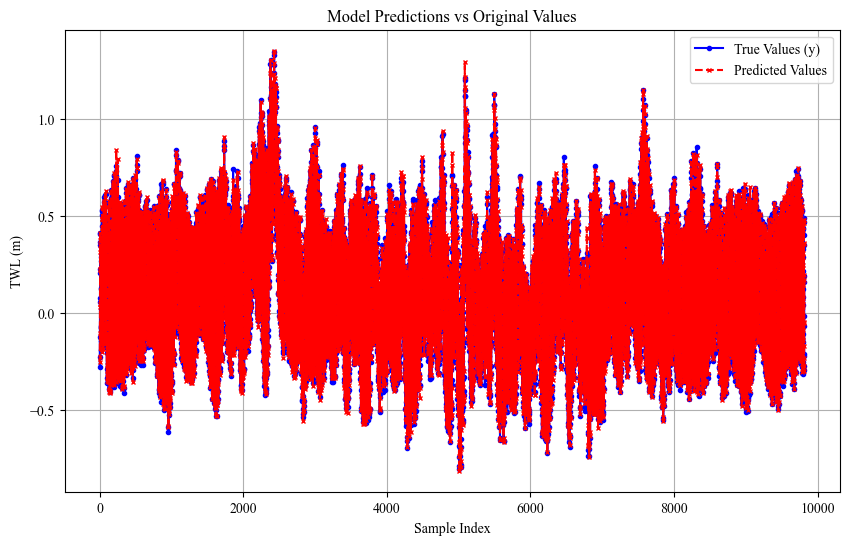

In [32]:
import matplotlib.pyplot as plt

# Assuming meta_predictions_original and y_meta_val_original are available from previous steps

# Plotting the original y values and the model predictions
plt.figure(figsize=(10, 6))
plt.plot(y_meta_val_original, label='True Values (y)', color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(meta_predictions_original, label='Predicted Values', color='red', marker='x', linestyle='--', markersize=3)
plt.title('Model Predictions vs Original Values')
plt.xlabel('Sample Index')
plt.ylabel('TWL (m)')
plt.legend()
plt.grid(True)
plt.show()